In [1]:
from os.path import dirname, abspath, join

from ramsis_hazard.core.schemas import \
    ScenarioSchema, HazardModelRunSchema
from ramsis_hazard.core.hazard_preparation_utils import \
    unique_timebins, name_scenario_directory, name_project_directory, \
    create_directory, get_model_weighting, get_results_for_timebin, \
    name_hazard_directory, \
    get_unique_model_configs, get_model_name_from_info, \
    create_model_weightings, create_inj_plan_info_list
from ramsis_hazard.core.hazard_file_preparation import \
    HazardRunFilePreparation
from ramsis_hazard.core.oq_run_utils import execute_haz_run
from ramsis_hazard.core.data_retrieval import get_forecastseries, \
    get_forecast, get_modelruns, get_modelrun_data

In [2]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [3]:
# set the path to the base dir of where we want to put the outputs
base_dir = "/home/sarsonl/repos/ramsis-hazard"
project_name = "forge_2022"
ws_url = 'http://ramsis.ethz.ch:8080/v1'
oq_url = 'http://localhost:8800'
forecastseries_id = 1


In [4]:
template_dir = "/home/sarsonl/repos/ramsis-hazard/examples"
job_config_template = join(template_dir, "oq_config_template.ini")
source_model_template = join(template_dir, "model_source_template.xml")
gsim_logic_tree = join(template_dir, "gsim_logic_tree.xml")


In [5]:
forecastseries = get_forecastseries(forecastseries_id, ws_url)

forecast_lon, forecast_lat = forecastseries.geometryextent.centroid.coords[0]
print("The hazard will be calculated for the point: \n forecast longitude:",
      forecast_lon, "forecast latitude: ", forecast_lat)
print("The forecast id should be taken from the following forecast ids: "
      f"{forecastseries.forecasts}")


The hazard will be calculated for the point: 
 forecast longitude: -112.8963896694454 forecast latitude:  38.50402146797724
The forecast id should be taken from the following forecast ids: [1]


In [6]:
# One forecast has modelruns for different model configs and different
# injection plans
forecast_id = 1
# Get forecast info
forecast = get_forecast(forecast_id, ws_url)


In [7]:
# Get all the modelrun ids and the injectionplan ids associated.
modelruns = get_modelruns(forecast_id, ws_url)
modelconfigs = get_unique_model_configs(modelruns)

# Add weights to different models
# In this simple case, each model will have equal weighting
modelweightings = create_model_weightings(modelconfigs, source_model_template)

# Create iterable for modelruns and injection plans
modelrun_inj_plan_list = create_inj_plan_info_list(modelruns)

# Each injectionplan is a new 'scenario' and will output a set of OQ input
# files for a different hazard run
_, inj_plan_ids, _ = zip(*modelrun_inj_plan_list)
unique_inj_plan_ids = set(inj_plan_ids)

project_dir = name_project_directory(base_dir, project_name)

In [8]:
def create_hazard_files_for_scenario(
        inj_plan_id, lon, lat, minaltitude, maxaltitude,
        forecast_starttime, forecast_endtime, project_dir,
        modelrun_inj_plan_list, ws_url, modelweightings,
        gsim_logic_tree, job_config_template):
    timebins = []
    scenario_dir = name_scenario_directory(project_dir, inj_plan_id)
    scenario = ScenarioSchema(
        id=inj_plan_id,
        haz_runs=[])
    # collect model runs for inj plans
    modelrun_ids = [item[0] for item in modelrun_inj_plan_list
                    if item[1] == inj_plan_id]

    for modelrun_id in modelrun_ids:
        resulttimebins = get_modelrun_data(modelrun_id, ws_url)
        model_name = get_model_name_from_info(
            modelrun_inj_plan_list, modelrun_id)
        assert model_name

        for result in resulttimebins:
            result.modelname = model_name
            model_weighting = get_model_weighting(model_name, modelweightings)
            result.weight = model_weighting.weight
            result.sourcemodeltemplate = model_weighting.sourcemodeltemplate

        timebins.extend(resulttimebins)
    forecast_timebins = unique_timebins(
        timebins, forecast_starttime, forecast_endtime)
    # print(f"Unique timebins found for forecast: {timebins}")
    # create files for hazard model run for each timebin.
    for haz_run_id, (starttime, endtime) in enumerate(forecast_timebins):
        model_timebins = get_results_for_timebin(
            resulttimebins, starttime, endtime)

        haz_run = HazardModelRunSchema(**dict(
            id=haz_run_id,
            describedinterval_start=starttime,
            describedinterval_end=endtime,
            gsimlogictree=gsim_logic_tree,
            jobconfigtemplate=job_config_template,
            sourcemodelfiles=[]))
        haz_dir = name_hazard_directory(
            scenario_dir, starttime, endtime, haz_run_id)
        create_directory(haz_dir)
        print("created haz directory: ", haz_dir)
        haz_run.oqinputdir = haz_dir
        output_dir = join(haz_dir, "outputs")
        create_directory(output_dir)
        haz_run.outputdir = output_dir

        file_preparation = HazardRunFilePreparation(
            model_timebins, haz_run, lat,
            lon, minaltitude, maxaltitude, output_dir)
        file_preparation.create_all()
        scenario.haz_runs.append(haz_run)
    return scenario


In [9]:
# Create hazard model run files per scenario
# where a scenario is defined by an injection plan.
scenarios = []
for inj_plan_id in unique_inj_plan_ids:
    scenario = create_hazard_files_for_scenario(
        inj_plan_id, forecast_lon, forecast_lat, forecastseries.minaltitude,
        forecastseries.maxaltitude, forecast.starttime, forecast.endtime,
        project_dir, modelrun_inj_plan_list, ws_url, modelweightings,
        gsim_logic_tree, job_config_template)
    scenarios.append(scenario)

print(f"Number of scenarios: {len(scenarios)}")


created haz directory:  /home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_0_2022-04-21T-14-00_2022-04-21T-14-09
created haz directory:  /home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_1_2022-04-21T-14-10_2022-04-21T-14-19
created haz directory:  /home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_2_2022-04-21T-14-20_2022-04-21T-14-29
created haz directory:  /home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_3_2022-04-21T-14-30_2022-04-21T-14-39
created haz directory:  /home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_4_2022-04-21T-14-40_2022-04-21T-14-49
created haz directory:  /home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_5_2022-04-21T-14-50_2022-04-21T-14-59
created haz directory:  /home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionSc

In [10]:
for scenario in scenarios:
    for haz_run in scenario.haz_runs:
        print("haz_run", haz_run)
        run_id = execute_haz_run(haz_run, scenario.id, oq_url)
        #haz_run_info.append((run_id, haz_run.outputdir)
        
        # Stop execution after one hazard run to just work with this data.
        raise StopExecution


haz_run id=0 runid=None describedinterval_start=datetime.datetime(2022, 4, 21, 14, 0) describedinterval_end=datetime.datetime(2022, 4, 21, 14, 9, 59) oqinputdir='/home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_0_2022-04-21T-14-00_2022-04-21T-14-09' jobconfigtemplate='/home/sarsonl/repos/ramsis-hazard/examples/oq_config_template.ini' gsimlogictree='/home/sarsonl/repos/ramsis-hazard/examples/gsim_logic_tree.xml' sourcemodelfiles=['EM1-MLE_Forge_BAYES_source_2022-04-21T-14-00_2022-04-21T-14-09_gridid_1411.xml', 'EM1-MLE_Forge_BAYES_source_2022-04-21T-14-00_2022-04-21T-14-09_gridid_1412.xml', 'EM1-MLE_Forge_BAYES_source_2022-04-21T-14-00_2022-04-21T-14-09_gridid_1413.xml', 'EM1-MLE_Forge_BAYES_source_2022-04-21T-14-00_2022-04-21T-14-09_gridid_1414.xml', 'EM1-MLE_Forge_BAYES_source_2022-04-21T-14-00_2022-04-21T-14-09_gridid_1415.xml', 'EM1-MLE_Forge_BAYES_source_2022-04-21T-14-00_2022-04-21T-14-09_gridid_1416.xml', 'EM1-MLE_Forge_BAYES_source_2022-0

In [12]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [14]:
# Execute following code per hazard model run
# Just work with one haz run to begin with
run_id = scenario.haz_runs[0].runid
output_dir = scenario.haz_runs[0].outputdir
# hazard curves investigation time ie.e 1year output from ramsis-hazard module
investigation_time = 1.

# weights of the source model i,e,
# EM1-MLE and EM1-BAYES if the models are aggregated in 
# postprocessesing 
# for this setting a default combined result is used with weight 1
weights = {'EM1-MLE_EM1-BAYES': 1.0}
# annual frequency of exceedance
afes = {}
#minute probabilities of exceedance
mpoes = {}

In [62]:
import requests
import json
import pandas as pd
import zipfile, io


def get_data(base_url: str, path: str):
    r = requests.get(f'{base_url}{path}')
    return r.json()
    

def get_zipped_data(base_url: str, path: str):
    r = requests.get(f'{base_url}{path}')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(output_dir)




results_id_list = get_data(oq_url, f'/v1/calc/{run_id}/results')

for result in results_id_list:
    if result["name"] == 'Hazard Curves':
        get_zipped_data(oq_url, f'/v1/calc/result/{result["id"]}?export_type=csv&dload=true')


In [63]:
import os
# There should be files available in the directory:
os.system(f'cd {output_dir} && ls -l')

total 16
-rw-rw-r-- 1 sarsonl sarsonl 612 Jun 30 15:56 hazard_curve-mean-PGV_493.csv
-rw-rw-r-- 1 sarsonl sarsonl 620 Jun 30 15:56 quantile_curve-0.1-PGV_493.csv
-rw-rw-r-- 1 sarsonl sarsonl 620 Jun 30 15:56 quantile_curve-0.5-PGV_493.csv
-rw-rw-r-- 1 sarsonl sarsonl 620 Jun 30 15:56 quantile_curve-0.9-PGV_493.csv


0

In [64]:
# get intensity measure levels (x-axis) of the hazard curve
def get_imls(df):
    imls = []
    for col in df.columns: 
        mtch = re.search("^poe-(\\d*\.\\d*)", col)
        if hasattr(mtch, 'groups'):
            imls.append(float(mtch.group(1)))
    return np.array(imls)

# return annual frequency of exceedance the y-axis
# note that the current hazard curves are per 1 year
# pay attention this is annual "frequency" based on annual "Probability" (poe)

def get_afe(poe):
    poe[poe > 0.999999] = 0.999999
    afe = -np.log(1. - poe) / investigation_time
    return afe


# Return the POE in minutes.
# 1) first conver POE to AFE, 
# 2) convert AFE to Minutes 
# 3) recompute the minute probability 
# the overall formula is: 
#  Probability of Exceedance (minutes) = 1 - (1 - Probability of Exceedance (years))^(1 / (365 * 24 * 60))

def get_mpoe(poe):
    poe[poe > 0.999999] = 0.999999
    minutes_per_year = 365 * 24 * 60
    minute_freq_exceedance = -np.log(1. - poe) / minutes_per_year
    minute_probability = 1 - np.exp(-minute_freq_exceedance)

    return minute_probability

In [65]:
#read OQ mean hazard curve
fname = f"{output_dir}/hazard_curve-mean-PGV_{run_id}.csv"
print(fname)
df_asm = pd.read_csv(fname, skiprows=1)
# intensity levels (x-axis)
imls = get_imls(df_asm)
# get the POE (annual)
poe_asm = df_asm.filter(regex='poe*').to_numpy()
afes['EM1-MLE_EM1-BAYES'] = get_afe(poe_asm)
#  Probability of Exceedance (minutes)
mpoes['EM1-MLE_EM1-BAYES'] = get_mpoe (poe_asm)

/home/sarsonl/repos/ramsis-hazard/Project_forge_2022/InjectionScenario_1/HazardModelRunId_0_2022-04-21T-14-00_2022-04-21T-14-09/outputs/hazard_curve-mean-PGV_493.csv


/tmp/ipykernel_29408/895689583.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(imls, mpoes[key][0, :], 'o', marker=sym[key], label=key)


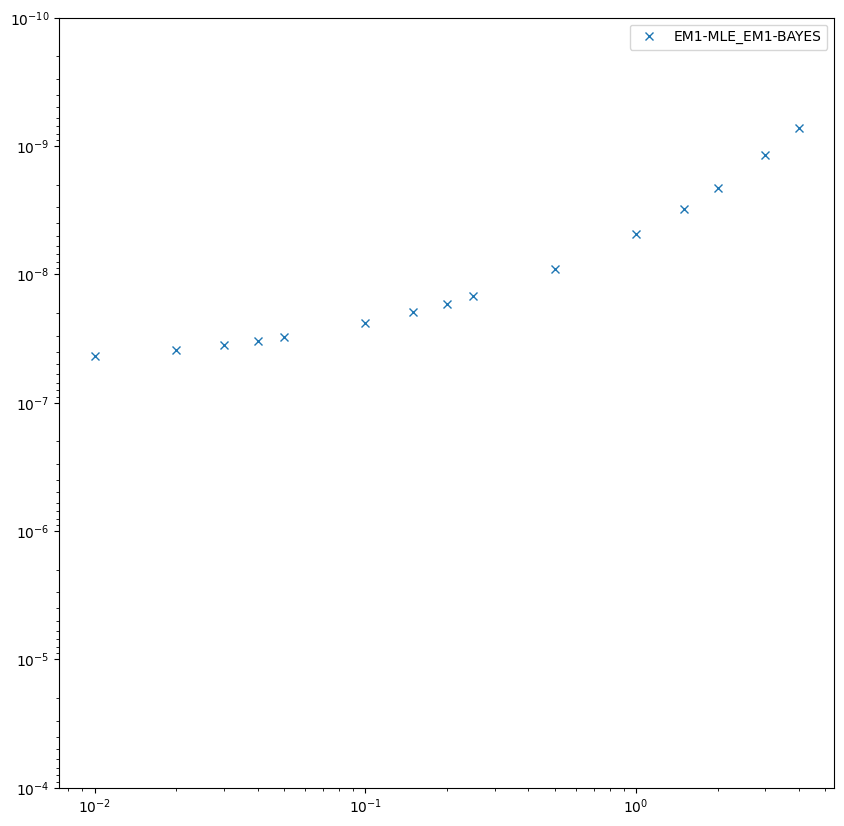

In [66]:
sym = {'EM1-MLE_EM1-BAYES': 'x'}
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)


for key in mpoes:
    ax.plot(imls, mpoes[key][0, :], 'o', marker=sym[key], label=key)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4, 1e-10])
ax.legend()